In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import numpy as np
from skimage.feature import hog
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np


In [ ]:
from skimage import color
from skimage.feature import hog
# Extract HOG features
def extract_HOG_features(img):
    gray_image = color.rgb2gray(img)
    feature = hog(gray_image, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(1, 1))
    return feature

<class 'numpy.ndarray'>
441


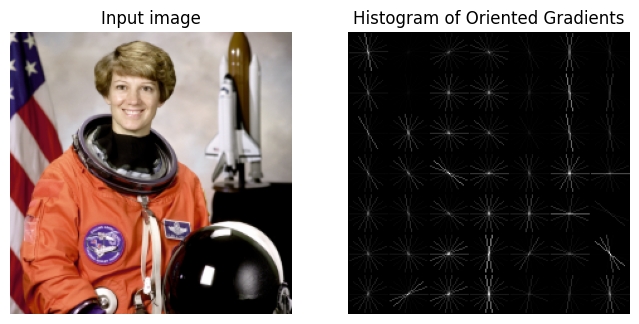

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from skimage import color
from skimage.transform import resize

image = data.astronaut()
image = resize(image, (224, 224))
print(type(image))

gray_img = color.rgb2gray(image)

fd, hog_image = hog(
    gray_img,
    orientations=9,
    pixels_per_cell=(32, 32),
    cells_per_block=(1, 1),
    visualize=True,
)

print(len(fd))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title("Input image")

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis("off")
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title("Histogram of Oriented Gradients")
plt.show()


In [ ]:
num_epochs = 10
batch_size = 100
learning_rate = 0.001


In [ ]:
import glob
from torchvision.datasets import ImageFolder

image_dim = 224

resize_transform = [
    transforms.Resize((image_dim, image_dim)),
]
common_transform = [
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
train_compose = transforms.Compose(resize_transform + common_transform)
test_compose = transforms.Compose(resize_transform + common_transform)
tensor_transform = transforms.Compose([transforms.ToTensor()])


class WheelchairDataset(ImageFolder):
    def __init__(self, ground_truth_csv, root, transform=None):
        self.ground_truth = pd.read_csv(ground_truth_csv)
        self.root = root
        self.img_paths = glob.glob(self.root + "*.png")
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        feature = extract_HOG_features(image)
        image = tensor_transform(image)
        return image, feature


In [ ]:
import torchvision

dataset_path = "drive/MyDrive/Thesis/CIFAR_HOG/dataset/"
ground_truth_train = "train.csv"
ground_truth_test = "test.csv"

# train_dataset = WheelchairDataset(
#     ground_truth_csv=ground_truth_train,
#     root=dataset_path + "train/",
#     transform=train_compose,
# )
# test_dataset = WheelchairDataset(
#     ground_truth_csv=ground_truth_test,
#     root=dataset_path + "test/",
#     transform=train_compose,
# )


def imshow(img):
    npimg = img if type(img) == np.ndarray else img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class CustomizedCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train, download, transform):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, idx):
        image, _ = super().__getitem__(idx)
        target = extract_HOG_features(np.transpose(image.numpy(), (1, 2, 0)))
        return image, target


train_dataset = CustomizedCIFAR10(
    root="drive/MyDrive/Thesis/CIFAR_HOG/data", train=True, download=True, transform=train_compose
)
test_dataset = CustomizedCIFAR10(
    root="drive/MyDrive/Thesis/CIFAR_HOG/data", train=False, download=True, transform=test_compose
)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)


In [ ]:
with torch.no_grad():
    pretrained_alexnet_model = torch.hub.load(
        "pytorch/vision:v0.9.0", "alexnet", pretrained=True
    )


Using cache found in /home2/ashwin_mittal/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 53 * 53, 4096)
        self.fc2 = nn.Linear(4096, 441)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        # x = nn.functional.relu(self.fc2(x))
        x = self.fc2(x)
        return x

# cnn = AlexSimplifiedNet()
# cnn.apply(init_weights)
cnn = Net()
cnn


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=441, bias=True)
)

In [ ]:
# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)


In [ ]:
losses = []
#validation loss: 0.0162
cnn.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441_v2.pth"))
old_val_loss = 10000 # big number
for epoch in range(num_epochs):
    cnn.train()
    total_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images = Variable(images.float())
        targets = Variable(targets.float())

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(
                "Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f"
                % (
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    len(train_dataset) // batch_size,
                    total_loss / (i + 1),
                )
            )

    print("Total Training loss: ")
    print(total_loss * batch_size / len(train_dataset))
    # Comapare with last loss
    cnn.eval()
    val_loss = 0.0
    with torch.no_grad():
      for images, targets in test_loader:
          images = Variable(images.float())
          targets = Variable(targets.float())
          outputs = cnn(images)
          val_loss += criterion(targets, outputs).item()
    print(
        "Test loss of the model on the %d test images: %.4f"
        % (len(test_dataset), val_loss * batch_size / len(test_dataset))
    )
    if old_val_loss > val_loss:
        torch.save(cnn.state_dict(), "/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441_v3.pth")
        old_val_loss = val_loss

Epoch : 1/10, Iter : 100/500,  Loss: 0.0206
Epoch : 1/10, Iter : 200/500,  Loss: 0.0182
Epoch : 1/10, Iter : 300/500,  Loss: 0.0174
Epoch : 1/10, Iter : 400/500,  Loss: 0.0170
Epoch : 1/10, Iter : 500/500,  Loss: 0.0168
Total Training loss: 
0.016799573244526984
Test loss of the model on the 10000 test images: 0.0160
Epoch : 2/10, Iter : 100/500,  Loss: 0.0158
Epoch : 2/10, Iter : 200/500,  Loss: 0.0158
Epoch : 2/10, Iter : 300/500,  Loss: 0.0158
Epoch : 2/10, Iter : 400/500,  Loss: 0.0157
Epoch : 2/10, Iter : 500/500,  Loss: 0.0157
Total Training loss: 
0.015742464354261756
Test loss of the model on the 10000 test images: 0.0160
Epoch : 3/10, Iter : 100/500,  Loss: 0.0157
Epoch : 3/10, Iter : 200/500,  Loss: 0.0157
Epoch : 3/10, Iter : 300/500,  Loss: 0.0157
Epoch : 3/10, Iter : 400/500,  Loss: 0.0157
Epoch : 3/10, Iter : 500/500,  Loss: 0.0157
Total Training loss: 
0.01571494933962822
Test loss of the model on the 10000 test images: 0.0159
Epoch : 4/10, Iter : 100/500,  Loss: 0.0157


**validation** loss: 0.0162

In [ ]:
cnn.eval()
total = 0
for images, targets in test_loader:
    images = Variable(images.float())
    targets = Variable(targets.float())
    outputs = cnn(images)
    total += criterion(targets, outputs).item()
print(
    "Test loss of the model on the %d test images: %.4f"
    % (len(test_dataset), total)
)


<Figure size 640x480 with 0 Axes>

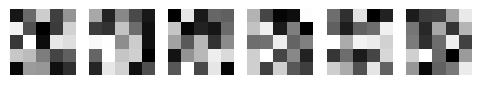

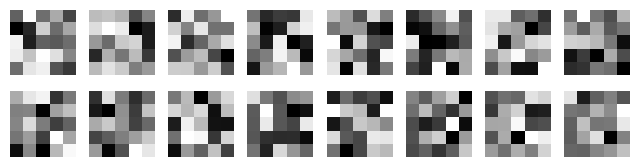

In [ ]:
def plot_kernels(tensor, num_cols=6, img_path=None):
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        ax1.imshow(tensor[i][0, :, :], cmap="gray")
        ax1.axis("off")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    if img_path:
        plt.savefig(img_path)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = cnn.modules()
model_layers = [i for i in cnn.children()]
first_layer = model_layers[0]
second_layer = model_layers[2]
first_kernels = first_layer.weight.data.numpy()
plot_kernels(first_kernels, 8, 'plot_1.png')
second_kernels = second_layer.weight.data.numpy()
plot_kernels(second_kernels, 8, 'plot_2.png')


In [ ]:

cnn.eval()
image = data.astronaut()

image = Image.fromarray(image).resize((224, 224))
hog_gt = extract_HOG_features(image)
hog_pred = cnn(tensor_transform(image).view(1,3,224,224))

print(hog_gt)
print(hog_pred)

image2 = data.chelsea()
image = Image.fromarray(image2).resize((224, 224))
hog_gt = extract_HOG_features(image)
hog_pred = cnn(tensor_transform(image).view(1,3,224,224))

print(hog_gt)
print(hog_pred)

[0.39142271 0.39142271 0.18822424 0.27023491 0.39142271 0.23334478
 0.26652627 0.39142271 0.39142271 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33683212 0.33683212 0.33683212 0.33683212 0.33683212 0.33683212
 0.33683212 0.33683212 0.30389633 0.30538716 0.29151502 0.34262801
 0.34262801 0.34262801 0.34262801 0.34262801 0.34262801 0.34262801
 0.40165819 0.19418575 0.22885677 0.25772689 0.29573224 0.37619368
 0.36128408 0.40165819 0.40165819 0.47136471 0.47136471 0.17193941
 0.08823827 0.11000263 0.17045752 0.18098546 0.47136471 0.47136471
 0.4472298  0.2401846  0.05903328 0.06992855 0.17688211 0.32029854
 0.4472298  0.4472298  0.4472298  0.40306815 0.40306815 0.40306815
 0.10029523 0.40306815 0.10860215 0.05799012 0.40306815 0.40306815
 0.34215328 0.34215328 0.34215328 0.34215328 0.34215328 0.34215328
 0.251891   0.34215328 0.34215328 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.3333

In [ ]:
import torch
from skimage import data
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

tensor_transform = transforms.Compose([transforms.ToTensor()])

cnn.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441.pth"))
cnn.eval()
print(cnn)
image = data.astronaut()

image = Image.fromarray(image).resize((224, 224))
hog_gt = extract_HOG_features(image)
hog_pred = cnn(tensor_transform(image).view(1,3,224,224))

#print(hog_gt)
#print(hog_pred)

d = euclidean_distances(hog_gt.reshape(1, 441), hog_pred.detach().numpy())[0][0]
print(d)

image2 = data.chelsea()
image = Image.fromarray(image2).resize((224, 224))
hog_gt2 = extract_HOG_features(image)
hog_pred2 = cnn(tensor_transform(image).view(1,3,224,224))

d = euclidean_distances(hog_gt2.reshape(1, 441), hog_pred2.detach().numpy())[0][0]
print(d)

d = euclidean_distances(hog_pred.detach().numpy(), hog_pred2.detach().numpy())[0][0]
print(d)

'''
class PartialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(16 * 53 * 53, 4096)
        #self.fc2 = nn.Linear(4096, 441)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        #x = nn.functional.relu(self.fc1(x))
        #x = nn.functional.relu(self.fc2(x))
        #x = self.fc2(x)
        return x

partial_model = PartialNet()
# Example assuming the target layer is at index 3 (replace with actual index)
target_layer_index = 5

#partial_model = torch.nn.Sequential(*list(cnn.children())[:target_layer_index])
print(partial_model)
partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441.pth"), strict=False)
hog_pred = partial_model(tensor_transform(image).view(1,3,224,224))
hog_pred = torch.flatten(hog_pred, 1)
print(hog_pred)
print(len(hog_pred[0]))
'''

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=441, bias=True)
)
2.6119705939337434
2.0930961679910833
2.0215752


'\nclass PartialNet(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.pool2 = nn.MaxPool2d(2, 2)\n        self.flatten = nn.Flatten()\n        #self.fc1 = nn.Linear(16 * 53 * 53, 4096)\n        #self.fc2 = nn.Linear(4096, 441)\n        # self.fc3 = nn.Linear(84, 10)\n\n    def forward(self, x):\n        x = self.pool(nn.functional.relu(self.conv1(x)))\n        x = self.pool2(nn.functional.relu(self.conv2(x)))\n        x = self.flatten(x) # flatten all dimensions except batch\n        #x = nn.functional.relu(self.fc1(x))\n        #x = nn.functional.relu(self.fc2(x))\n        #x = self.fc2(x)\n        return x\n\npartial_model = PartialNet()\n# Example assuming the target layer is at index 3 (replace with actual index)\ntarget_layer_index = 5\n\n#partial_model = torch.nn.Sequential(*list(cnn.children())[:target_layer_index])\nprint(partia

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 53 * 53, 4096)
        self.fc2 = nn.Linear(4096, 441)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        # x = nn.functional.relu(self.fc2(x))
        x = self.fc2(x)
        return x

# Create an instance of your model
model = Net()

# Print the summary
summary(model, (3, 224, 224))  # Input size should match your input image size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
           Flatten-5                [-1, 44944]               0
            Linear-6                 [-1, 4096]     184,094,720
            Linear-7                  [-1, 441]       1,806,777
Total params: 185,904,369
Trainable params: 185,904,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.86
Params size (MB): 709.17
Estimated Total Size (MB): 714.60
----------------------------------------------------------------


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Define your data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 15

#from torch.utils.data import Subset
#subset_indices = list(range(1000))

train_dataset = datasets.ImageFolder(root='Path_to_training_dataset', transform=transform)
#train_subset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = datasets.ImageFolder(root='Path_to_test(validation)_dataset', transform=transform)
#val_subset = Subset(val_dataset, subset_indices)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

class HogNet(nn.Module):
    def __init__(self, len_hog_vector):
        super(HogNet, self).__init__()
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        return x

len_hog_vector = 441
hogNet = HogNet(len_hog_vector)

hogNet.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_441_v2.pth"), strict=False)

for param in hogNet.parameters():
    param.requires_grad = False

class YourProblemClassifier(nn.Module):
    def __init__(self, hogNet):
        super(YourProblemClassifier, self).__init__()
        self.hogNet = hogNet
        self.output = nn.Linear(44944, 800) # 800 is number of classes

    def forward(self, x):
        x = self.hogNet(x)
        x = nn.functional.softmax(self.output(x), dim=1)
        return x

# Create an instance of the extended model
yourProblemClassifier = YourProblemClassifier(hogNet)

